# Notebook 3: Analysis of Market Mechanisms

**Goal:** Analyze if Western economic theories (Phillips Curve, Okun's Law) apply equally to China.

**Methods:** Scatterplots (Regression Lines), Spearman Correlation (Robust), FDR Correction (Multiple Testing).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Load Data
try:
    df_analysis = pd.read_pickle("imf_data_clean.pkl")
    print("Data loaded.")
except FileNotFoundError:
    print("Error: Run Notebook 01 first!")

countries_to_analyze = ['Switzerland', 'Germany', 'United States', 'China']

# Helper function for Effect Size (VL 8)
def interpret_strength(rho):
    abs_rho = abs(rho)
    if abs_rho < 0.1: return "Negligible"
    elif abs_rho < 0.3: return "Small"
    elif abs_rho < 0.5: return "Medium"
    else: return "Strong"

Data loaded.


## 1. Hypothesis 2: The Phillips Curve
**$H_0$:** There is no significant correlation between Unemployment Rate and Inflation.

**Expected:** Negative correlation (Trade-off).

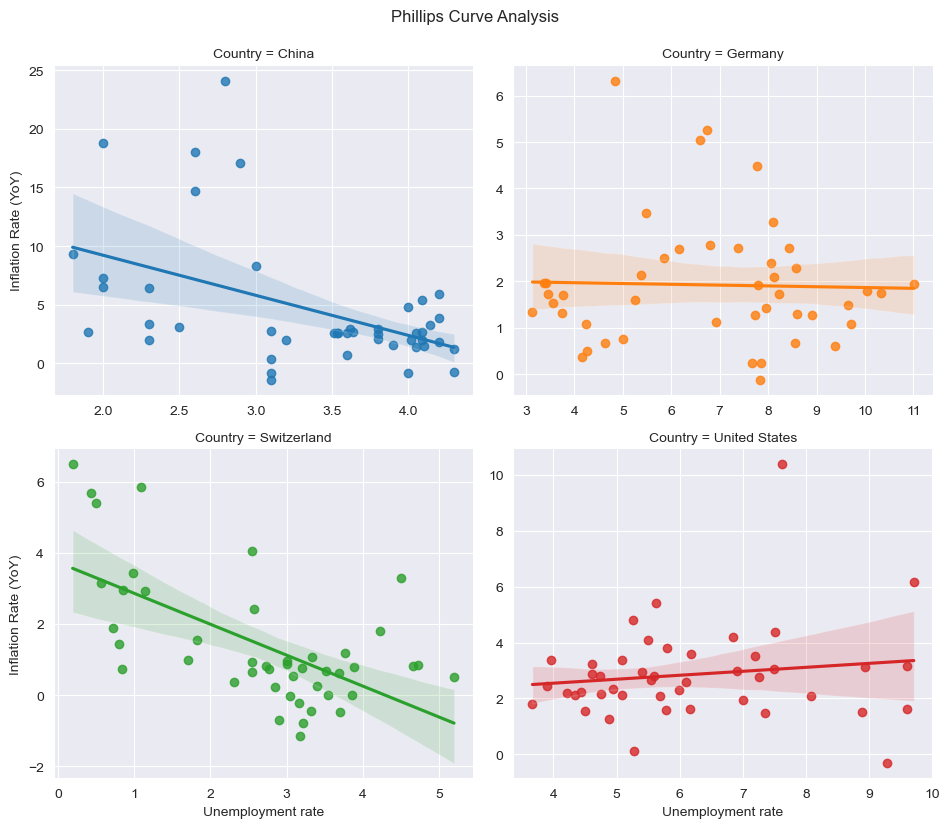

--- Hypothesis Test: Phillips Curve (Spearman + FDR) ---
         Country  Correlation    Strength  p-Value (FDR) Significant?
0    Switzerland      -0.5169      Strong         0.0011          Yes
1        Germany      -0.0125  Negligible         0.9350           No
2  United States       0.1198       Small         0.5777           No
3          China      -0.4530      Medium         0.0036          Yes


In [2]:
df_phillips = df_analysis[df_analysis['Subject Descriptor'].isin(['Inflation Rate (YoY)', 'Unemployment rate'])]
df_phillips_wide = df_phillips.pivot_table(index=['Country', 'Year'], columns='Subject Descriptor', values='Value').reset_index().dropna()

# Visualize
sns.lmplot(data=df_phillips_wide, x='Unemployment rate', y='Inflation Rate (YoY)', col='Country', col_wrap=2, hue='Country', height=4, aspect=1.2, facet_kws={'sharex': False, 'sharey': False})
plt.suptitle("Phillips Curve Analysis", y=1.03)
plt.show()

# Test (Spearman + FDR)
results = []
print("--- Hypothesis Test: Phillips Curve (Spearman + FDR) ---")

for country in countries_to_analyze:
    data = df_phillips_wide[df_phillips_wide['Country'] == country]
    corr, p_val = stats.spearmanr(data['Unemployment rate'], data['Inflation Rate (YoY)'])
    results.append({'Country': country, 'Method': 'Spearman', 'Correlation': corr, 'Strength': interpret_strength(corr), 'p-Value (raw)': p_val})

df_res = pd.DataFrame(results)
reject, pvals_corrected, _, _ = multipletests(df_res['p-Value (raw)'], alpha=0.05, method='fdr_bh')
df_res['p-Value (FDR)'] = pvals_corrected
df_res['Significant?'] = df_res['p-Value (FDR)'].apply(lambda p: "Yes" if p < 0.05 else "No")

print(df_res[['Country', 'Correlation', 'Strength', 'p-Value (FDR)', 'Significant?']].round(4))

## 2. Hypothesis 3: Okun's Law
**$H_0$:** There is no significant correlation between GDP Growth and Unemployment.

**Expected:** Negative correlation (Growth creates jobs).

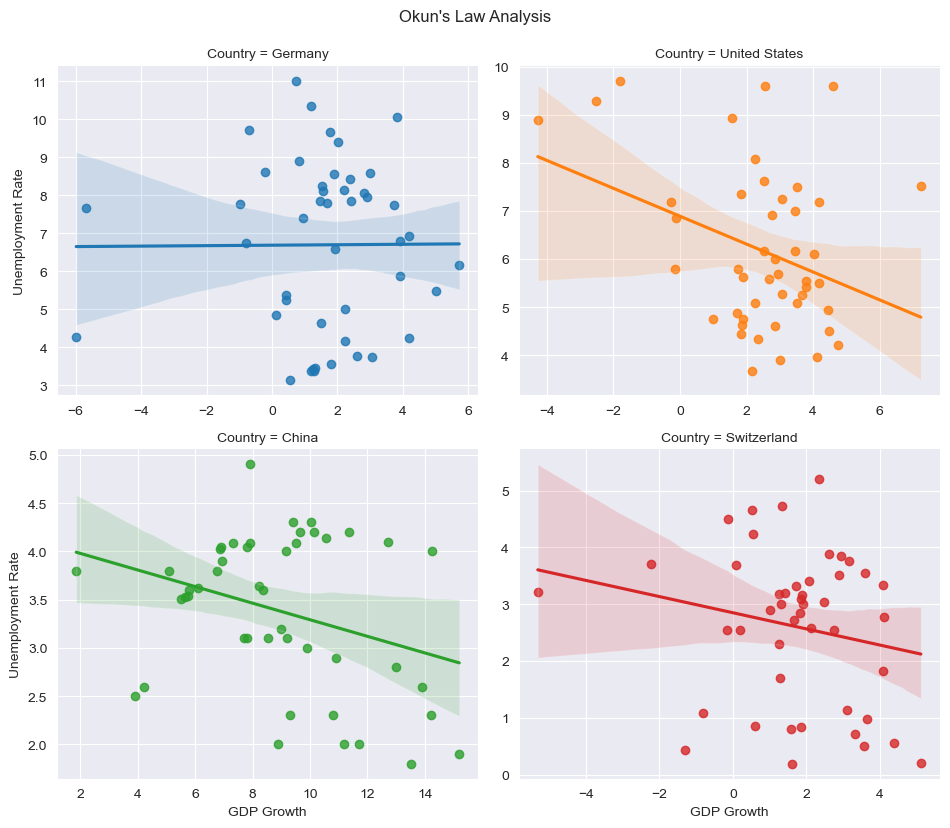


--- Hypothesis Test: Okun's Law (Spearman + FDR) ---
         Country  Correlation    Strength  p-Value (FDR) Significant?
0    Switzerland      -0.1574       Small         0.3949           No
1        Germany       0.0008  Negligible         0.9958           No
2  United States      -0.1859       Small         0.3949           No
3          China      -0.1652       Small         0.3949           No


In [3]:
# Prepare Data
df_gdp = df_analysis[df_analysis['Subject Descriptor'] == 'GDP Growth Rate (YoY)'][['Country', 'Year', 'Value']].rename(columns={'Value': 'GDP Growth'})
df_unemp = df_analysis[df_analysis['Subject Descriptor'] == 'Unemployment rate'][['Country', 'Year', 'Value']].rename(columns={'Value': 'Unemployment Rate'})
df_okun = pd.merge(df_gdp, df_unemp, on=['Country', 'Year'], how='inner').dropna()

# Visualize
sns.lmplot(data=df_okun, x='GDP Growth', y='Unemployment Rate', col='Country', col_wrap=2, hue='Country', height=4, aspect=1.2, facet_kws={'sharex': False, 'sharey': False})
plt.suptitle("Okun's Law Analysis", y=1.03)
plt.show()

# Test (Spearman + FDR)
results_okun = []
print("\n--- Hypothesis Test: Okun's Law (Spearman + FDR) ---")

for country in countries_to_analyze:
    data = df_okun[df_okun['Country'] == country]
    corr, p_val = stats.spearmanr(data['GDP Growth'], data['Unemployment Rate'])
    results_okun.append({'Country': country, 'Method': 'Spearman', 'Correlation': corr, 'Strength': interpret_strength(corr), 'p-Value (raw)': p_val})

df_res_okun = pd.DataFrame(results_okun)
reject, pvals_corrected, _, _ = multipletests(df_res_okun['p-Value (raw)'], alpha=0.05, method='fdr_bh')
df_res_okun['p-Value (FDR)'] = pvals_corrected
df_res_okun['Significant?'] = df_res_okun['p-Value (FDR)'].apply(lambda p: "Yes" if p < 0.05 else "No")

print(df_res_okun[['Country', 'Correlation', 'Strength', 'p-Value (FDR)', 'Significant?']].round(4))

### Conclusion: Market Mechanisms

**1. Test Results (Statistical Significance)**
Contrary to traditional economic theory, our analysis **cannot confirm** Okun's Law for the selected countries. The relationship between GDP growth and the unemployment rate is **not statistically significant** for any of the four nations ($p_{adj} > 0.05$).

**2. Economic Magnitude (Effect Size)**
The observed correlations are **negligible to small** across the board (ranging from $\rho \approx 0.00$ to $-0.19$). While the US, China, and Switzerland show a slight negative trend direction, the effect is too weak to be distinguished from random noise.

**3. Interpretation**
The data suggests a **decoupling** of economic growth and labor market performance for the observed period. This implies that GDP growth does not automatically translate into lower unemployment in these economies, likely due to structural factors (e.g., labor market regulations, demographic shifts, or productivity gains).